# Preamble
Title: Cryptocurrency Information Web Scraper

Author: Kyle Weidner

Email: kweidne2 at msudenver.edu

Last Update: 2021-09-26

# Information
This report presents graphical information about a specific cryptocurrency gathered from a web scraper. This information includes historical price data and trade volume data.

# Dataset
The data gathered by this webscraper can be found here: https://www.coingecko.com/en/coins/harmony/historical_data/usd?end_date=2021-09-25&start_date=2021-06-27#panel
Web scraping techniques were used to gather and structure the data into a usable and readable form. Daily price data is gathered and processed, as well as daily trade volume data. This data is then presented visually for easier interpretation.

The script below automatically gathers the data from the source URL and stores this data into lists for harmony_daily_prices and harmony_volumes.

In [6]:
# CS390Z - Introduction to Data Mining - Fall 2021
# Instructor: Thyago Mota
# Author(s): Kyle Weidner
# Description: A Cryptocurrency web scraper

from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date, timedelta


def min_max(data, mins, maxs, interval=(0, 1)):
    return [int(((data[i] - mins) / (maxs - mins) * (interval[1] - interval[0]) + interval[0]) * 100000) / 100000 for i in range(len(data))]


end_date = date.today()
start_date = end_date - timedelta(days=90)

HARMONY_URL = "https://www.coingecko.com/en/coins/harmony/historical_data/usd?end_date=" + str(end_date) + "&start_date=" + str(start_date) + "#panel"

harmony = requests.get(HARMONY_URL)
h_soup = BeautifulSoup(harmony.content, 'html.parser')

harmony_daily_prices = []
harmony_volumes = []
dates = []
open_prices = []
close_prices = []

# row_data contains the <tr> for each day
row_data = h_soup.find_all('tr')

# We skip the first two rows because we do not need that data
for r in row_data[2:]:
    dates.append(str(r.findChildren()[0].get_text().strip()))
    open_price = float(r.findChildren()[3].get_text().strip().replace('$', ''))
    open_prices.append(open_price)
    close_price = float(r.findChildren()[4].get_text().strip().replace('$', ''))
    close_prices.append(close_price)
    harmony_daily_prices.append(round((open_price + close_price) / 2, 4))
    harmony_volumes.append(int(r.findChildren()[2].get_text().strip().replace("\n", "").replace("$", "").replace(",", "")))

dataset = pd.DataFrame(
    {"Dates": dates,
     "Open Price ($)": open_prices,
     "Close Price ($)": close_prices,
     "Daily Trade Volume ($)": harmony_volumes
     }
)
dataset.to_csv('dataset.csv', encoding='UTF-8', index=False)

# Summary Statistics

In [7]:
# CS390Z - Introduction to Data Mining - Fall 2021
# Instructor: Thyago Mota
# Author(s): Kyle Weidner
# Description: A Cryptocurrency web scraper

from scraper import *
import numpy as np

print("*** Summary Statistics ***")
print(f'Volumes Range: [{np.min(harmony_volumes)}, {np.max(harmony_volumes)}]')
print('Volumes Mean: {:.2f}'.format(np.mean(harmony_volumes)))
print('Volumes Median: {:.2f}'.format(np.median(harmony_volumes)))
print('Volumes STD: {:.2f}'.format(np.std(harmony_volumes)))
print(f'Price Range: [{np.min(harmony_daily_prices)}, {np.max(harmony_daily_prices)}]')
print('Price Mean: {:.2f}'.format(np.mean(harmony_daily_prices)))
print('Price Median: {:.2f}'.format(np.median(harmony_daily_prices)))
print('Price STD: {:.2f}'.format(np.std(harmony_daily_prices)))

*** Summary Statistics ***
Volumes Range: [14864735, 812739013]
Volumes Mean: 142827939.50
Volumes Median: 80450404.00
Volumes STD: 151463885.64
Price Range: [0.0586, 0.2438]
Price Mean: 0.13
Price Median: 0.12
Price STD: 0.05


# Histogram Visualization of Price Action

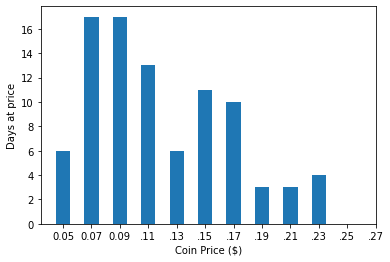

In [8]:
# CS390Z - Introduction to Data Mining - Fall 2021
# Instructor: Thyago Mota
# Author(s): Kyle Weidner
# Description: A Cryptocurrency web scraper

from scraper import *
import matplotlib.pyplot as plt

counts, bins, _ = plt.hist(
    harmony_daily_prices,
    bins=[0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27],
    rwidth=0.5
)
bins = [x + .01 for x in bins]
axes = plt.gca()
axes.set_xticks(bins)
axes.set_xticklabels(['0.05', '0.07', '0.09', '.11', '.13', '.15', '.17', '.19', '.21', '.23', '.25', '.27'])
plt.xlabel("Coin Price ($)")
plt.ylabel("Days at price")
plt.show()

# Box Plot Visualization of Daily Trade Volumes

Outlier: 2021-07-22 - $621574356
Outlier: 2021-07-24 - $812739013
Outlier: 2021-08-21 - $407377867
Outlier: 2021-08-22 - $605518239
Outlier: 2021-08-23 - $436601551
Outlier: 2021-08-24 - $416656737


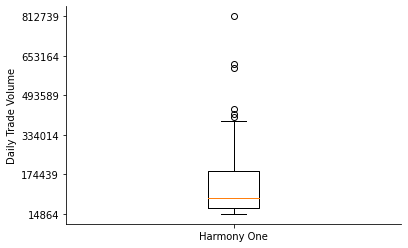

In [9]:
# CS390Z - Introduction to Data Mining - Fall 2021
# Instructor: Thyago Mota
# Author(s): Kyle Weidner
# Description: A Cryptocurrency web scraper

from scraper import *
import matplotlib.pyplot as plt
import numpy as np

volumes_range = (max(harmony_volumes)) - (min(harmony_volumes))
volumes_labels = [str(int((i/10*volumes_range + min(harmony_volumes))/1000)) for i in range(0, 11, 2)]
volumes_normalized = min_max(harmony_volumes, min(harmony_volumes), max(harmony_volumes))

plt.boxplot(volumes_normalized)

outliers = {}
q1 = np.quantile(volumes_normalized, 0.25)
q3 = np.quantile(volumes_normalized, 0.75)
med = np.median(volumes_normalized)
iqr = q3-q1
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
i = 0
for a in volumes_normalized:
    if a > upper_bound:
        outliers.update({dates[i]: harmony_volumes[i]})
    if a < lower_bound:
        outliers.update({dates[i]: harmony_volumes[i]})
    i += 1

for date, outlier in outliers.items():
    print("Outlier:", date + ' -', '$' + str(outlier))

axes = plt.gca()
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.set_yticks([i/10 for i in range(0, 11, 2)])
axes.set_yticklabels(volumes_labels)
axes.set_xticklabels(["Harmony One"])
plt.ylabel('Daily Trade Volume')
plt.show()

# Line chart of Daily Price from Last 90 Days
Unsure of how to format the x-axis ticks so the dates aren't all overlapping.

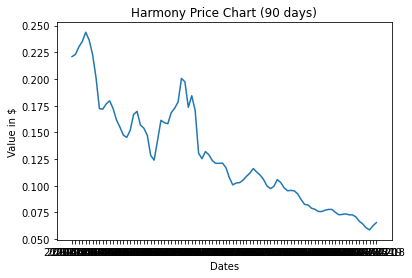

In [10]:
# CS390Z - Introduction to Data Mining - Fall 2021
# Instructor: Thyago Mota
# Author(s): Kyle Weidner
# Description: A Cryptocurrency web scraper

from scraper import *
import matplotlib.pyplot as plt

harmony_daily_prices.reverse()
dates.reverse()
plt.plot(dates, harmony_daily_prices)
plt.title("Harmony Price Chart (90 days)")
plt.xlabel("Dates")
plt.ylabel("Value in $")
plt.show()